# *SOURCE*
https://www.youtube.com/watch?v=doDUihpj6ro&t=7339s
https://github.com/nicknochnack/ActionDetectionforSignLanguage

In [1]:
! pip install PyQt5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.8/357.8 KB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 13.9 MB/s eta 0:00:00


In [2]:
!pip install tensorflow==2.8.1 tensorflow-gpu==2.8.1 opencv-python mediapipe 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 36.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully un

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [4]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('/content/Tutorial_LSTM_MP/Complete_Face_Data') 

# Actions that we try to detect
actions = np.array(['LirikKanan', 'LirikKiri', 'MenolehKanan', 'MenolehKiri', 'Normal', 'TutupMata'])

# Thirty videos worth of data
no_sequences = 27

# Videos are going to be 30 frames in length
sequence_length = 50

In [5]:
! git clone https://github.com/nickbp760/Tutorial_LSTM_MP.git

Cloning into 'Tutorial_LSTM_MP'...
remote: Enumerating objects: 28087, done.
remote: Counting objects: 100% (5075/5075), done.
remote: Compressing objects: 100% (5067/5067), done.
remote: Total 28087 (delta 4), reused 5073 (delta 2), pack-reused 23012
Receiving objects: 100% (28087/28087), 573.94 MiB | 17.60 MiB/s, done.
Resolving deltas: 100% (209/209), done.
Updating files: 100% (22879/22879), done.


### **Preprocess Data and Create Labels and Features**

The label map containts the action label

In [6]:
label_map = {label:num for num, label in enumerate(actions)}

In [7]:
label_map

{'LirikKanan': 0,
 'LirikKiri': 1,
 'MenolehKanan': 2,
 'MenolehKiri': 3,
 'Normal': 4,
 'TutupMata': 5}

load the the data that have been prepared before

In [8]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [9]:
478*3

1434

In [10]:
np.array(sequences).shape

(162, 50, 1434)

DEFINE X (Input) and y (Output)

In [11]:
X = np.array(sequences)
print(X.shape)
y = to_categorical(labels).astype(int)
print(y.shape)

(162, 50, 1434)
(162, 6)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [13]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    

### **Build and Train Neural Network**

In [14]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [15]:
model = Sequential()
model.add(GRU(128, return_sequences=True, activation='relu', input_shape=(50,1434)))
model.add(GRU(64, return_sequences=True, activation='relu'))
model.add(GRU(128, return_sequences=False, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model.optimizer.lr.assign(0.001)

In [18]:
history = model.fit(X_train, y_train, epochs=200, callbacks=[tb_callback], validation_data = (X_test, y_test))

Epoch 1/200
5/5 [==============================] - 2s 471ms/step - loss: 0.3824 - categorical_accuracy: 0.8414 - val_loss: 0.3876 - val_categorical_accuracy: 0.8824
Epoch 2/200
5/5 [==============================] - 4s 737ms/step - loss: 0.3110 - categorical_accuracy: 0.8966 - val_loss: 0.4002 - val_categorical_accuracy: 0.8824
Epoch 3/200
5/5 [==============================] - 3s 671ms/step - loss: 0.3610 - categorical_accuracy: 0.8345 - val_loss: 0.1842 - val_categorical_accuracy: 0.9412
Epoch 4/200
5/5 [==============================] - 2s 326ms/step - loss: 0.3059 - categorical_accuracy: 0.9034 - val_loss: 0.5404 - val_categorical_accuracy: 0.8235
Epoch 5/200
5/5 [==============================] - 2s 317ms/step - loss: 0.3041 - categorical_accuracy: 0.9103 - val_loss: 0.2378 - val_categorical_accuracy: 0.9412
Epoch 6/200
5/5 [==============================] - 2s 325ms/step - loss: 0.2888 - categorical_accuracy: 0.8690 - val_loss: 0.3699 - val_categorical_accuracy: 0.9412
Epoch 7/20

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 128)           600576    
                                                                 
 gru_1 (GRU)                 (None, 50, 64)            37248     
                                                                 
 gru_2 (GRU)                 (None, 128)               74496     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 733,158
Trainable params: 733,158
Non-trai

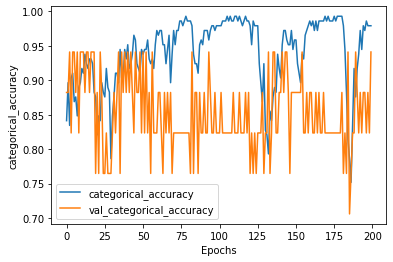

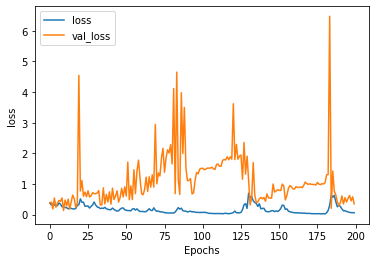

In [19]:
model.summary()
model.save('/content/Tutorial_LSTM_MP/Weight_model/actionGRUFaceNikoComplete.h5')
plot_graphs(history, 'categorical_accuracy')
plot_graphs(history, 'loss')

In [20]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(50,1434)))
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=False, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model.optimizer.lr.assign(0.001)

In [22]:
history = model.fit(X_train, y_train, epochs=200, callbacks=[tb_callback], validation_data = (X_test, y_test))

Epoch 1/200
5/5 [==============================] - 7s 748ms/step - loss: 202.9537 - categorical_accuracy: 0.1655 - val_loss: 408.9063 - val_categorical_accuracy: 0.3529
Epoch 2/200
5/5 [==============================] - 1s 251ms/step - loss: 300.3853 - categorical_accuracy: 0.1655 - val_loss: 460.5071 - val_categorical_accuracy: 0.1176
Epoch 3/200
5/5 [==============================] - 1s 280ms/step - loss: 291.2504 - categorical_accuracy: 0.1517 - val_loss: 234.5194 - val_categorical_accuracy: 0.0588
Epoch 4/200
5/5 [==============================] - 1s 258ms/step - loss: 136.6591 - categorical_accuracy: 0.1793 - val_loss: 202.1964 - val_categorical_accuracy: 0.2353
Epoch 5/200
5/5 [==============================] - 1s 264ms/step - loss: 199.1765 - categorical_accuracy: 0.1586 - val_loss: 247.7599 - val_categorical_accuracy: 0.0588
Epoch 6/200
5/5 [==============================] - 1s 271ms/step - loss: 178.3929 - categorical_accuracy: 0.1724 - val_loss: 160.5198 - val_categorical_acc

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 128)           800256    
                                                                 
 lstm_1 (LSTM)               (None, 50, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 128)               98816     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 6)                 198       
                                                                 
Total params: 969,318
Trainable params: 969,318
Non-tr

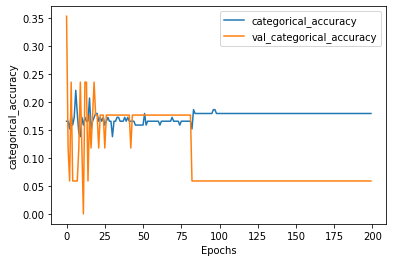

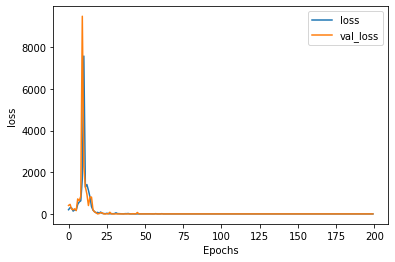

In [23]:
model.summary()
model.save('/content/Tutorial_LSTM_MP/Weight_model/actionLSTMFaceNikoComplete.h5')
plot_graphs(history, 'categorical_accuracy')
plot_graphs(history, 'loss')